In [1]:
import cv2
from sensor_msgs.msg import Image
from cv_bridge import CvBridge
import rospy

import pyrealsense2
from realsense_depth import *
import numpy as np
from matplotlib import pyplot as plt

import open3d as o3d
from open3d_ros_helper import open3d_ros_helper as orh
from scipy import spatial
from scipy.spatial.transform import Rotation as R
import math
import tf2_ros, tf
import geometry_msgs.msg
import PyKDL

image = None

rospy.init_node("my_pic", anonymous=True)

tfbuffer = tf2_ros.Buffer()
listener = tf2_ros.TransformListener(tfbuffer)
br = tf2_ros.TransformBroadcaster()
t = geometry_msgs.msg.TransformStamped()

bridge = CvBridge()
loop_rate = rospy.Rate(0.5) # Node cycle rate (in Hz).
np.set_printoptions(suppress=True)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::

            >>> angle_between((1, 0, 0), (0, 1, 0))
            1.5707963267948966
            >>> angle_between((1, 0, 0), (1, 0, 0))
            0.0
            >>> angle_between((1, 0, 0), (-1, 0, 0))
            3.141592653589793
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

def grab_frame():
    
    frame_color=rospy.wait_for_message('/camera/color/image_raw', Image, timeout=None) #wait_for_message(topic, topic_type, timeout=None): 
    cv_image_color = bridge.imgmsg_to_cv2(frame_color, desired_encoding='rgb8')
    
    frame_depth = rospy.wait_for_message('/camera/depth/image_raw', Image, timeout=None) #wait_for_message(topic, topic_type, timeout=None): 
    cv_image_depth = bridge.imgmsg_to_cv2(frame_depth)
    
    return cv_image_color, cv_image_depth

In [74]:
def visualize_rgbd(rgbd_image):
    print(rgbd_image)
    #o3d.visualization.draw_geometries([rgbd_image])
    
    #intrinsic = o3d.camera.PinholeCameraIntrinsic()
    #intrinsic.intrinsic_matrix =  [[462.1379699707031, 0.0, 320.0], [0.0, 462.1379699707031, 240.0], [0.0, 0.0, 1.0]]
    #intrinsic.intrinsic_matrix =  [[347.99755859375, 0.0, 320.0], [0.0, 347.99755859375, 240.0], [0.0, 0.0, 1.0]]
    #intrinsic.intrinsic_matrix =  [[602.71783447, 0.0, 313.06835938], [0.0, 601.61364746, 230.37461853], [0.0, 0.0, 1.0]]
    
    #w = 640
    #h = 480
    #fx = 602.71783447
    #fy = 601.61364746
    #cx = 313.06835938
    #cy = 230.37461853
    
    #Color frame ROS camera
    #w = 640
    #h = 480
    #fx = 462.1379699707031
    #fy = 462.1379699707031
    #cx = 320.0
    #cy = 240.0
    
    #Depth frame ROS camera
    w = 640
    h = 480
    fx = 347.99755859375
    fy = 347.99755859375
    cx = 320.0
    cy = 240.0    
    
    
    intrinsic = o3d.camera.PinholeCameraIntrinsic(w, h, fx,fy, cx, cy)
    intrinsic.intrinsic_matrix = [[fx, 0, cx], [0, fy, cy], [0, 0, 1]]
    
    cam = o3d.camera.PinholeCameraParameters()
    cam.intrinsic = intrinsic
    
    #cam.extrinsic = np.array([[0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 0.], [0., 0., 0., 1.]])
    #pcd = o3d.geometry.create_point_cloud_from_rgbd_image(rgbd_image, cam.intrinsic, cam.extrinsic)
    
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image, cam.intrinsic)
    #pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,intrinsic)
    
    pcd.transform([[1, 0, 0, 0], [0, -1, 0, 0], [0, 0, -1, 0], [0, 0, 0, 1]]) # Flip it, otherwise the pointcloud will be upside down.
    
    #o3d.visualization.draw_geometries([pcd])
    
    return pcd
    
    
def tst_dataset(color_frame,depth_frame):
    color_raw = o3d.geometry.Image(np.asarray(color_frame))
    depth_raw = o3d.geometry.Image(np.asarray(depth_frame.astype(np.uint16)) )
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(color_raw, depth_raw, convert_rgb_to_intensity=False)
    pcd = visualize_rgbd(rgbd_image)
    return pcd


def box_pos(x_coord, y_coord, width, height, centered=0):
    if centered == 0:
        start_point = (x_coord, y_coord) # represents the top left corner of rectangle
        end_point = (x_coord+width-1, y_coord+height-1)  # represents the bottom right corner of rectangle
    elif centered == 1:
        new_x = x_coord - (np.floor(width/2)-1).astype(int)
        new_y = y_coord - (np.floor(height/2)-1).astype(int)
        start_point = (new_x, new_y) 
        end_point = (new_x+width, new_y+height)
    return start_point, end_point


def fetch_transform(tfbuffer,frame1,frame2,quat=0):
    flag = 0
    while flag==0:
        try:
            trans = tfbuffer.lookup_transform(frame1, frame2, rospy.Time(),rospy.Duration(8.0))
            #print (trans)
            trans = trans.transform  #save translation and rotation
            rot = PyKDL.Rotation.Quaternion(* [ trans.rotation.x,trans.rotation.y,trans.rotation.z,trans.rotation.w] )
            #print (' '.join( [ str(eval('trans.rotation.'+c)) for c in 'xyzw'] ))
            ypr = [ i  / np.pi * 180 for i in rot.GetEulerZYX() ]
            #print(ypr[2],ypr[1],ypr[0])

            break
        except (tf2_ros.LookupException, tf2_ros.ConnectivityException, tf2_ros.ExtrapolationException) as e:
            #print ("Fail", e)
            continue
    if quat==0:
        return trans.translation.x, trans.translation.y, trans.translation.z, ypr[2], ypr[1], ypr[0]
    elif quat==1:
        return trans.translation.x, trans.translation.y, trans.translation.z, trans.rotation.x, trans.rotation.y, trans.rotation.z, trans.rotation.w
    
    

In [75]:
color_frame, depth_frame = grab_frame()
print("color frame:",color_frame.shape, " Depth frame:",depth_frame.shape)

#Check center pixel distance

point = (320, 240)

#color_frame, depth_frame = grab_frame()

distance = depth_frame[point[1], point[0]]
print("Center of image:", distance, "mm")

color frame: (480, 640, 3)  Depth frame: (480, 640)
Center of image: 240 mm



start_point,end_point = box_pos(320, 240, 10, 10, centered=1)  #x,y,width,height, 0-- top left coord, 1--- center coord

cf = color_frame
for i in range (color_frame.shape[0]):
    for j in range (color_frame.shape[1]):
        if depth_frame[i][j] == 0:
            cf[i][j] = [0 , 0, 0] 

plt.imshow(cf)
plt.show()
window_name = 'Filtered_image'  # Window name in which image is displayed

cv2.rectangle(cf, start_point, end_point, (0, 0, 255), 1)
cv2.imshow(window_name, cf)
cv2.waitKey(0)
cv2.destroyAllWindows()


#color_frame_crop = cf[start_point[1]:end_point[1], start_point[0]:end_point[0]]

color_frame_crop = cf[start_point[1]:end_point[1], start_point[0]:end_point[0]]
depth_frame_crop = depth_frame[start_point[1]:end_point[1], start_point[0]:end_point[0]]

print(depth_frame_crop.shape)
zz=depth_frame_crop.T
print(zz.shape)

#cv2.imshow("cropped", depth_frame_crop)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

In [76]:
pt_cloud = tst_dataset(color_frame, depth_frame)


RGBDImage of size 
Color image : 640x480, with 3 channels.
Depth image : 640x480, with 1 channels.
Use numpy.asarray to access buffer data.


In [77]:
downpcd = pt_cloud.voxel_down_sample(voxel_size=0.01)
#o3d.visualization.draw_geometries([downpcd])

print("Recompute the normal of the downsampled point cloud")
downpcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.05, max_nn=30)) #radius in meters

#o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

v1_normal = np.array(downpcd.normals)
v1_normal_pts = np.array(downpcd.points)


Recompute the normal of the downsampled point cloud


In [78]:
print("Align normals towards camera") #orient_normals_towards_camera_location(self, camera_location=array([0.0, 0.0, 0.0]))

downpcd.orient_normals_towards_camera_location(camera_location=[0.0, 0.0, 1.0])

#o3d.visualization.draw_geometries([downpcd], point_show_normal=True)

v2_camera = np.array(downpcd.normals)
v2_camera_pts = np.array(downpcd.points)
v2_camera

Align normals towards camera


array([[ 0.00771064, -0.0250567 ,  0.99965629],
       [ 0.00771064, -0.0250567 ,  0.99965629],
       [ 0.0000811 , -0.02218559,  0.99975387],
       ...,
       [ 0.0001042 , -0.00812882,  0.99996696],
       [ 0.00141771, -0.02568894,  0.99966898],
       [ 0.0023681 , -0.02913873,  0.99957257]])

In [79]:
idx = np.where(abs(v1_normal_pts[:,2]) < (distance/1000)+0.01)[0] #fetch all indexes of values less than distance of center of img 0.3 in column 3 of rec
#idx = np.where(abs(v1_normal_pts[:,2]) < abs(v1_normal_pts[:,2]).max()-0.02)[0] #Remove ground

filtered_Pt_Cloud = downpcd.select_by_index(idx, invert=False)
o3d.visualization.draw_geometries([filtered_Pt_Cloud], point_show_normal=True)
nor = np.array(filtered_Pt_Cloud.normals)
pts = np.array(filtered_Pt_Cloud.points)
filtered_Pt_Cloud.get_center()


array([ 0.01554711,  0.00196953, -0.24039699])

In [80]:
distance,index = spatial.KDTree(pts).query( filtered_Pt_Cloud.get_center() ) #find coordinates 
                                                                             #that are closest to the center 

print(distance)
print(index)
print()
print("Center Coordinates(ground truth):",filtered_Pt_Cloud.get_center())
print("Points Coordinates(estimated center point):",pts[index])
print("Normal Coordinates(Normal of estimated center point):",nor[index])
print("Tilt Angle:", np.round(np.degrees(angle_between((0,0,1), nor[index]))) ) 

0.0011026185047190644
774

Center Coordinates(ground truth): [ 0.01554711  0.00196953 -0.24039699]
Points Coordinates(estimated center point): [ 0.01620701  0.00275864 -0.23999999]
Normal Coordinates(Normal of estimated center point): [ 0.00235363 -0.02618148  0.99965444]
Tilt Angle: 2.0


In [81]:
print('Angle: 0')
print()
print('Positive X count:', np.sum(np.array(nor[:,0]) >= 0, axis=0), 
      '  Positive Y count:',np.sum(np.array(nor[:,1]) >= 0, axis=0), 
      '  Positive Z count:',np.sum(np.array(nor[:,2]) >= 0, axis=0), '     Out of:',len(nor[:,0]))

Angle: 0

Positive X count: 1274   Positive Y count: 7   Positive Z count: 1433      Out of: 1433


In [82]:
print("Estimated angle between Normal and Camera")
print()
arr = np.array([])
for i in range(len(nor)):
    arr = np.append(arr, [np.round(np.degrees(angle_between((0,0,1), nor[i])))])
    print(i+1," ", np.round(np.degrees(angle_between((0,0,1), nor[i]))) )

Estimated angle between Normal and Camera

1   1.0
2   1.0
3   1.0
4   1.0
5   1.0
6   0.0
7   0.0
8   0.0
9   0.0
10   0.0
11   0.0
12   2.0
13   2.0
14   2.0
15   2.0
16   2.0
17   2.0
18   2.0
19   2.0
20   2.0
21   2.0
22   2.0
23   2.0
24   2.0
25   2.0
26   2.0
27   1.0
28   1.0
29   1.0
30   1.0
31   1.0
32   1.0
33   1.0
34   1.0
35   0.0
36   0.0
37   0.0
38   0.0
39   0.0
40   0.0
41   0.0
42   2.0
43   2.0
44   1.0
45   2.0
46   1.0
47   1.0
48   1.0
49   1.0
50   1.0
51   1.0
52   1.0
53   1.0
54   0.0
55   0.0
56   0.0
57   0.0
58   0.0
59   0.0
60   1.0
61   0.0
62   1.0
63   1.0
64   1.0
65   1.0
66   1.0
67   1.0
68   1.0
69   1.0
70   1.0
71   1.0
72   1.0
73   0.0
74   0.0
75   0.0
76   0.0
77   0.0
78   1.0
79   1.0
80   1.0
81   1.0
82   0.0
83   0.0
84   0.0
85   0.0
86   0.0
87   1.0
88   1.0
89   1.0
90   1.0
91   1.0
92   1.0
93   1.0
94   1.0
95   1.0
96   0.0
97   1.0
98   1.0
99   1.0
100   1.0
101   1.0
102   2.0
103   2.0
104   2.0
105   1.0
106   1.0
107  

938   1.0
939   1.0
940   1.0
941   1.0
942   1.0
943   1.0
944   1.0
945   3.0
946   2.0
947   1.0
948   1.0
949   1.0
950   1.0
951   1.0
952   1.0
953   1.0
954   0.0
955   1.0
956   1.0
957   1.0
958   1.0
959   1.0
960   0.0
961   1.0
962   1.0
963   1.0
964   1.0
965   1.0
966   1.0
967   1.0
968   1.0
969   1.0
970   1.0
971   1.0
972   3.0
973   1.0
974   2.0
975   2.0
976   1.0
977   2.0
978   1.0
979   2.0
980   1.0
981   1.0
982   2.0
983   2.0
984   1.0
985   1.0
986   1.0
987   1.0
988   1.0
989   1.0
990   1.0
991   1.0
992   1.0
993   0.0
994   1.0
995   1.0
996   1.0
997   1.0
998   1.0
999   0.0
1000   2.0
1001   1.0
1002   1.0
1003   1.0
1004   1.0
1005   1.0
1006   0.0
1007   2.0
1008   1.0
1009   1.0
1010   2.0
1011   0.0
1012   1.0
1013   0.0
1014   1.0
1015   0.0
1016   1.0
1017   1.0
1018   1.0
1019   1.0
1020   1.0
1021   1.0
1022   1.0
1023   1.0
1024   1.0
1025   2.0
1026   1.0
1027   0.0
1028   1.0
1029   1.0
1030   1.0
1031   1.0
1032   1.0
1033   1.0
1034  

In [83]:
arr.mean()

1.107466852756455

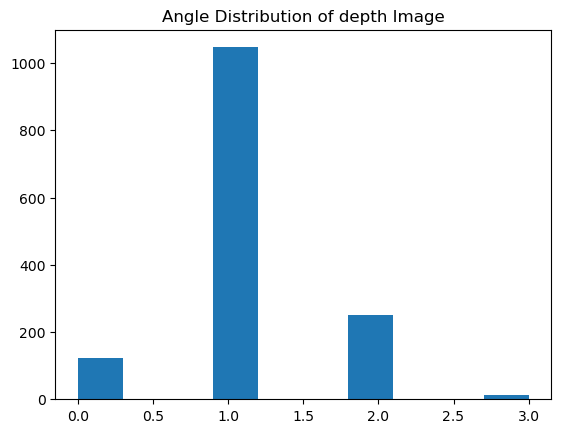

[[   0.  122.]
 [   1. 1047.]
 [   2.  252.]
 [   3.   12.]]


In [84]:
hi=np.histogram(arr,bins=10)
np.set_printoptions(suppress=True)
plt.hist(arr,bins=10)
plt.title("Angle Distribution of depth Image")
plt.show()
unique, counts = np.unique(arr, return_counts=True)
print(np.asarray((unique, counts)).T)


In [85]:
unique, counts

(array([0., 1., 2., 3.]), array([ 122, 1047,  252,   12]))

In [86]:


def getRotation(v1, v2):

    vec1 = v1 / np.linalg.norm(v1)
    vec2 = v2 / np.linalg.norm(v2)

    angle = math.acos(np.dot(vec1, vec2))
    vector = np.cross(vec1, vec2)/np.linalg.norm(np.cross(vec1, vec2))
    
    print("Angle:",angle)
    print("Vector:",vector)
    print()
    
    #Rotation = filtered_Pt_Cloud.get_rotation_matrix_from_axis_angle(angle*vector) #alternative Open3D lib.
    Rotation = R.from_rotvec(angle*vector)
    
    return Rotation, angle, vector


In [100]:
rot,angle, vector = getRotation([0,0,1], nor[index])

print("Axis-Angle:", angle*vector)
print()

print("Rotation Matrix:")
print(rot.as_matrix())
print()

r = rot.as_euler("xyz", degrees=True)
r_quat = rot.as_quat()            #x,y,z,w format

print("Roll:", r[0], "Pitch:", r[1], "Yaw:", r[2])
print()
print("In Quaternion form xyzw:",r_quat)

Angle: 0.02629008703431054
Vector: [ 0.99598362  0.08953558 -0.        ]

Axis-Angle: [ 0.0261845  0.0023539 -0.       ]

Rotation Matrix:
[[ 0.99999723  0.00003082  0.00235363]
 [ 0.00003082  0.99965721 -0.02618148]
 [-0.00235363  0.02618148  0.99965444]]

Roll: 1.5002638902629872 Pitch: 0.13485301367632982 Yaw: 0.0017656340681333625

In Quaternion form xyzw: [ 0.01309187  0.00117692 -0.          0.99991361]


In [96]:
##Broadcast the frame to tf2 under child name connected to given frame

Roll = -180
Pitch = 0
Yaw = +90



t.header.frame_id = "camera_depth_optical_frame"
t.child_frame_id = "plane"


t.header.stamp = rospy.Time.now()
t.transform.translation.x = pts[index][0]
t.transform.translation.y = pts[index][1]
t.transform.translation.z = -pts[index][2] #becaues z in opposite dirn

#quat = tf.transformations.quaternion_from_euler(Roll,Pitch,Yaw)

t.transform.rotation.x = r_quat[0]
t.transform.rotation.y = r_quat[1]
t.transform.rotation.z = r_quat[2]
t.transform.rotation.w = r_quat[3]

br.sendTransform(t)
#rate.sleep()
aa = fetch_transform(tfbuffer,'world', 'plane',quat=0)
aa=np.round(aa,3)
print("Trans:","X", aa[0], "Y", aa[1],"Z",aa[2])
print("Rot (deg):",aa[3],aa[4],aa[5])

Trans: X 0.295 Y 0.001 Z 0.216
Rot (deg): -179.58 -0.188 -90.003


In [97]:
aa = fetch_transform(tfbuffer,'world', 'camera_depth_optical_frame',quat=0)
aa=np.round(aa,3)
print("Trans:",aa[0],aa[1],aa[2])
print("Rot (deg):",aa[3],aa[4],aa[5])

Trans: 0.303 0.017 0.456
Rot (deg): 178.92 -0.053 -90.002


In [98]:
aa = fetch_transform(tfbuffer,'plane', 'camera_depth_optical_frame',quat=0)
aa=np.round(aa,3)
print("Trans:",aa[0],aa[1],aa[2])
print("Rot (deg):",aa[3],aa[4],aa[5])

Trans: -0.016 -0.009 -0.24
Rot (deg): -1.5 -0.135 0.002


In [99]:
Box_pose = [0.3, 0, 0.2, 0, 0, 0]
Box_pose

[0.3, 0, 0.2, 0, 0, 0]